In [10]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchaudio
from torch import nn
import pytorch_lightning as pl
from ema_pytorch import EMA
import IPython.display as ipd
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

### Functions & Models
- Functions and models definitions

In [11]:
# Load model checkpoint
ckpt_path = "./logs/ckpts/2023-06-02-09-25-33/last.ckpt" # path to checkpoint
config_path = "./logs/runs/2023-06-02-09-25-33/.hydra/config.yaml" # path to model config

In [33]:
def plot_mel_spectrogram(sample):
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        n_mels=80,
        center=True,
        norm="slaney",
    )

    spectrogram = transform(torch.mean(sample, dim=0)) # downmix and cal spectrogram
    spectrogram = torchaudio.functional.amplitude_to_DB(spectrogram, 1.0, 1e-10, 80.0)

    # Plot the Mel spectrogram
    fig = plt.figure(figsize=(7, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Frame')
    plt.ylabel('Mel Bin')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    
    return fig

In [13]:
class Model(pl.LightningModule):
    def __init__(
        self,
        lr: float,
        lr_beta1: float,
        lr_beta2: float,
        lr_eps: float,
        lr_weight_decay: float,
        ema_beta: float,
        ema_power: float,
        model: nn.Module,
    ):
        super().__init__()
        self.lr = lr
        self.lr_beta1 = lr_beta1
        self.lr_beta2 = lr_beta2
        self.lr_eps = lr_eps
        self.lr_weight_decay = lr_weight_decay
        self.model = model
        self.model_ema = EMA(self.model, beta=ema_beta, power=ema_power)

### Instantiate model

In [5]:
model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=2, # U-Net: number of input/output (audio) channels
    channels=[32, 32, 64, 64, 128, 128, 256, 256], # U-Net: channels at each layer
    factors=[1, 2, 2, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler # The diffusion sampler used
)
model = Model(
    lr=1e-4,
    lr_beta1=0.95,
    lr_beta2=0.999,
    lr_eps=1e-6,
    lr_weight_decay=1e-3,
    ema_beta=0.995,
    ema_power=0.7,
    model=model
)

### Check if GPU available

In [6]:
# Assign to GPU
if torch.cuda.is_available():
    model = model.to('cuda')
    print(f"Device: {model.device}")

Device: cuda:0


In [7]:
# Load model checkpoint
checkpoint = torch.load(ckpt_path, map_location='cpu')['state_dict']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [37]:
# Define diffusion paramters
sample_length = 2**15 # 32768
sr = 44100
num_samples = 1 # number of samples to generate
num_steps = 50 # number of diffusion steps (10-100)

Generated Sample 1


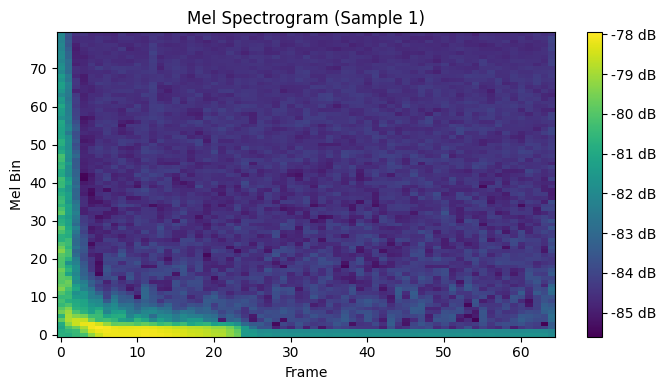

In [38]:
model.eval()
with torch.no_grad():
    for i in range(num_samples):
        noise = torch.randn((1, 2, sample_length), device=model.device) # [batch_size, in_channels, length]
        generated_sample = model.model_ema.ema_model.sample(noise, num_steps=num_steps) # Suggested num_steps 10-100

        print(f"Generated Sample {i+1}")
        display(ipd.Audio(generated_sample.squeeze(0).cpu(), rate=sr))

        fig = plot_mel_spectrogram(generated_sample.squeeze(0).cpu())
        plt.title(f"Mel Spectrogram (Sample {i+1})")
        plt.show()
        
        torch.cuda.empty_cache()

In [ ]:
# TODO: Implement "style transfer"